In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten
from tensorflow.keras.models import Model

import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Read dataset
df = pd.read_csv("/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv", names = ["label", "description"], header = None)
df.head()

,label,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


## Exploratory Data Analysis

In [4]:
# View shape of dataframe
df.shape

(50425, 2)

In [5]:
# See if there is missing data
df.isnull().sum(axis = 0) # One missing description
df.dropna(inplace = True) # Dropping one value out of 50425 

In [6]:
# Check class labels balance
df["label"].value_counts() # Class imbalance

label
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64

In [7]:
# Change the labels into sparse categorical
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

In [8]:
print(df["label"].value_counts())
labels_dict = {0 : "Books", 
               1 : "Clothing & Accessories",
               2 : "Electronics",
               3 : "Household"
              }

label
3    19313
0    11820
2    10621
1     8670
Name: count, dtype: int64


## Data Modeling

In [9]:
model_comparison_dict = {
    "model" : [],
    "time" : [],
    "accuracy": []
}

### Simple Bag-of-words Approach

In [10]:
# Vectorize descriptions
vectorizer = CountVectorizer() 
X = vectorizer.fit_transform(df["description"])

In [11]:
labels = df["label"].tolist()

In [12]:
# Partition the data into train, validation, and test
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.2, random_state=42)

### Naive Bayes Model

In [13]:
nb_classifier = MultinomialNB()

start_time = time.time()
nb_classifier.fit(X_train, y_train)
end_time = time.time()
nb_time = end_time - start_time

In [14]:
# Model Evaluation
y_pred = nb_classifier.predict(X_valid)

In [15]:
nb_accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", nb_accuracy)

Accuracy: 0.9494298463063956


In [16]:
# Add to dictionary
model_comparison_dict["model"].append("Naive Bayes")
model_comparison_dict["time"].append(nb_time)
model_comparison_dict["accuracy"].append(nb_accuracy)

In [17]:
print("Classification Report:")
print(classification_report(y_valid, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2378
           1       0.94      0.99      0.97      1750
           2       0.94      0.94      0.94      2082
           3       0.95      0.96      0.95      3875

    accuracy                           0.95     10085
   macro avg       0.95      0.95      0.95     10085
weighted avg       0.95      0.95      0.95     10085



### SVM Modeling

In [18]:
svm_classifier = SVC(kernel='linear')

start_time = time.time()
svm_classifier.fit(X_train, y_train)
end_time = time.time()

svm_time = end_time - start_time

In [19]:
y_pred = svm_classifier.predict(X_valid)

In [20]:
# Accuracy
svm_accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", svm_accuracy)

Accuracy: 0.9768963807635102


In [21]:
# Add to dictionary
model_comparison_dict["model"].append("SVM")
model_comparison_dict["time"].append(svm_time)
model_comparison_dict["accuracy"].append(svm_accuracy)

In [22]:
# Classification Report
print("Classification Report:")
print(classification_report(y_valid, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2378
           1       0.98      0.98      0.98      1750
           2       0.97      0.97      0.97      2082
           3       0.98      0.97      0.98      3875

    accuracy                           0.98     10085
   macro avg       0.98      0.98      0.98     10085
weighted avg       0.98      0.98      0.98     10085



### Deep Learning Approaches

In [23]:
# Use tensorflow tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["description"])
vocab_size = len(tokenizer.word_index) + 1

In [24]:
# Tensorflow padding
sequences = tokenizer.texts_to_sequences(df["description"])
X = pad_sequences(sequences)

In [25]:
# Partition the data
X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)

In [26]:
def build_model(vocab_size, sequence_length, embedding_dim):
    input_sequence = Input(shape = (sequence_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim = embedding_dim) (input_sequence)
    flattened_layer = Flatten() (embedding_layer)
    dense_layer = Dense(128, activation="relu") (flattened_layer)
    output_layer = Dense(4, activation = "softmax") (dense_layer)
    
    model = Model(inputs = input_sequence, outputs = output_layer)
    return model

In [27]:
# Initialize the model
sequence_length = X.shape[1]
embedding_dim = 64
model = build_model(vocab_size = vocab_size, sequence_length = sequence_length, embedding_dim = embedding_dim)

In [28]:
# Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [29]:
# Compile the model
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ["accuracy"])

In [30]:
# Add Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor = "val_loss",
                    patience = 3,
                    verbose = 1,
                    mode = "min",
                    restore_best_weights = True)

In [31]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size = 1024, epochs=20, validation_data=(X_test, y_test), callbacks = [early_stopping])
end_time = time.time()

dl_time = end_time - start_time

Epoch 1/20
40/40 [==============================] - 24s 555ms/step - loss: 4.0485 - accuracy: 0.3547 - val_loss: 0.9183 - val_accuracy: 0.6322
Epoch 2/20
40/40 [==============================] - 21s 531ms/step - loss: 0.5254 - accuracy: 0.8401 - val_loss: 0.3234 - val_accuracy: 0.9293
Epoch 3/20
40/40 [==============================] - 21s 531ms/step - loss: 0.2188 - accuracy: 0.9530 - val_loss: 0.2037 - val_accuracy: 0.9570
Epoch 4/20
40/40 [==============================] - 21s 531ms/step - loss: 0.1299 - accuracy: 0.9726 - val_loss: 0.1568 - val_accuracy: 0.9641
Epoch 5/20
40/40 [==============================] - 21s 531ms/step - loss: 0.0860 - accuracy: 0.9826 - val_loss: 0.1321 - val_accuracy: 0.9707
Epoch 6/20
40/40 [==============================] - 21s 531ms/step - loss: 0.0602 - accuracy: 0.9889 - val_loss: 0.1164 - val_accuracy: 0.9739
Epoch 7/20
40/40 [==============================] - 21s 531ms/step - loss: 0.0432 - accuracy: 0.9925 - val_loss: 0.1065 - val_accuracy: 0.9755

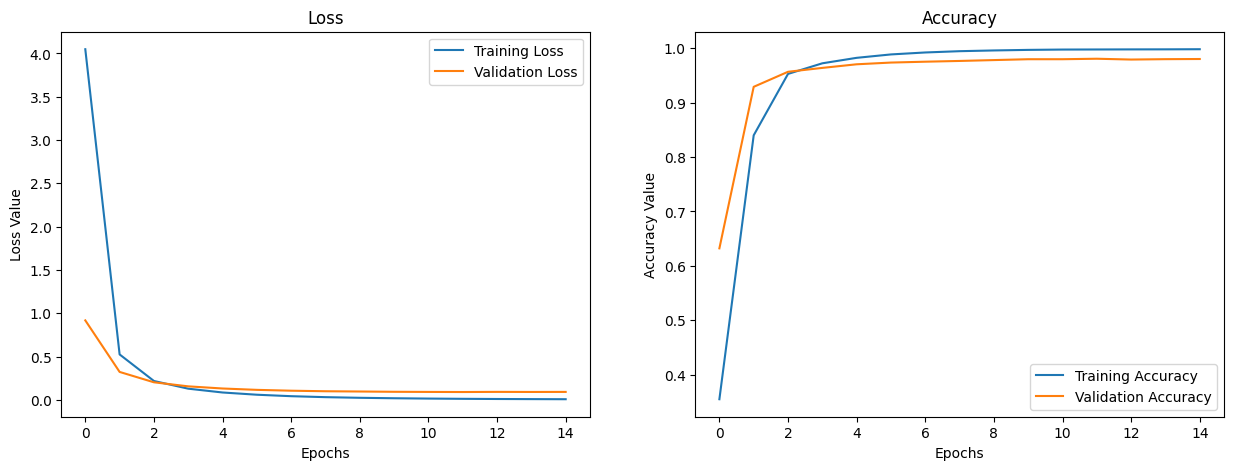

In [32]:
# Plot accuracy and loss curves
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axes[0].plot(history.history["loss"], label = "Training Loss")
axes[0].plot(history.history["val_loss"], label = "Validation Loss")
axes[1].plot(history.history["accuracy"], label = "Training Accuracy")
axes[1].plot(history.history["val_accuracy"], label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[0].set_ylabel("Loss Value")
axes[0].set_xlabel("Epochs")
axes[1].set_title("Accuracy")
axes[1].set_ylabel("Accuracy Value")
axes[1].set_xlabel("Epochs")

axes[0].legend()
axes[1].legend()
plt.show()

In [33]:
dl_accuracy = model.evaluate(X_test, y_test)[1]

316/316 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9810


In [34]:
dl_accuracy

0.980961799621582

In [35]:
# Add to dictionary
model_comparison_dict["model"].append("Deep Learning")
model_comparison_dict["time"].append(dl_time)
model_comparison_dict["accuracy"].append(dl_accuracy)

## Comparing Models

In [36]:
model_comparison_dict

{'model': ['Naive Bayes', 'SVM', 'Deep Learning'],
 'time': [0.04811668395996094, 179.78993582725525, 322.1493911743164],
 'accuracy': [0.9494298463063956, 0.9768963807635102, 0.980961799621582]}

In [38]:
model_comparison_df = pd.DataFrame.from_dict(model_comparison_dict)

In [39]:
model_comparison_df

,model,time,accuracy
0,Naive Bayes,0.048117,0.949430
1,SVM,179.789936,0.976896
2,Deep Learning,322.149391,0.980962
